# Applications of SOS Programming in Flowpipe Construction

Flowpipe construction consists of under or over-approximating the sets of states reachable by dynamical systems. Recently a method has been developed for the class of polynomial ODEs with uncertain initial states (see [1], abbreviated `XFZ18under`). This method consists of reducing the Hamilton-Jacobi-Bellman equation to a hierarchy of semidefinite programs.

In this notebook we consider the problem of approximating the flowpipe of a system of polynomial ODEs using `XFZ18under`. This is a Julia implementation that relies on the JuMP ecosystem (`JuMP`, `PolyJuMP`, `SumOfSquares`, `MathProgInterface`, `MathOptInterfaceMosek`) and the `JuliaAlgebra` ecosystem (`MultivariatePolynomials`, `DynamicPolynomials`). The implementation is evaluated on a set of standard benchmarks from formal verification and control engineering domains.

---

**References:**

- [1] Xue, B., Fränzle, M., & Zhan, N. (2018, April). [Under-Approximating Reach Sets for Polynomial Continuous Systems. In Proceedings of the 21st International Conference on Hybrid Systems: Computation and Control (part of CPS Week) (pp. 51-60). ACM.](https://dl.acm.org/citation.cfm?id=3178133)

**Quick links to documentation:**

- www.juliaopt.org/SumOfSquares.jl/latest/
- https://sums-of-squares.github.io/sos/index.html

## Van-der-Pol system

Consider the following van-der-Pol system:

$$
\dot{x}_1 = x_2 \\
\dot{x}_2 = -0.2x_1 + x_2 - 0.2x_1^2 x_2
$$

In [1]:
using MultivariatePolynomials,
      JuMP,
      PolyJuMP,
      SumOfSquares,
      DynamicPolynomials,
      MathOptInterfaceMosek,
      MathematicalSystems

const ∂ = differentiate

differentiate (generic function with 18 methods)

In [2]:
# symbolic variables
@polyvar x₁ x₂ t

# time duration (scaled, see dynamics below)
T = 1.0 

# dynamics
f = 2 * [x₂, -0.2*x₁ + x₂ - 0.2*x₁^2*x₂] 

# set of initial states X₀ = {x: V₀(x) <= 0}
V₀ = x₁^2 + x₂^2 - 0.25

# constraints Y = {x: g(x) >= 0} compact search space Y x [0, T]
g = 25 - x₁^2 - x₂^2

# degree of the relaxation
k = 6

# monomial vector up to order k, 0 <= sum_i alpha_i <= k, if alpha_i is the exponent of x_i
X = monomials([x₁, x₂], 0:k)
XT = monomials([x₁, x₂, t], 0:k)

# create a SOS JuMP model to solve with Mosek
model = SOSModel(with_optimizer(MosekOptimizer))

# add unknown Φ to the model
@variable(model, Φ, Poly(XT))

# jacobian
∂t = α -> ∂(α, t)
∂xf = α -> ∂(α, x₁) * f[1] + ∂(α, x₂) * f[2] 
LΦ = ∂t(Φ) + ∂xf(Φ)

# Φ(x, t) at time 0
Φ₀ = subs(Φ, t => 0.)

# scalar variable
@variable(model, ϵ)

dom1 = @set t*(T-t) >= 0 && g >= 0
dom2 = @set g >= 0
@constraint(model, ϵ >= 0.)
@constraint(model, LΦ ∈ SOSCone(), domain = dom1)
@constraint(model, ϵ - LΦ ∈ SOSCone(), domain = dom1)
@constraint(model, Φ₀ - V₀ ∈ SOSCone(), domain = dom2)
@constraint(model, ϵ + V₀ - Φ₀ ∈ SOSCone(), domain = dom2)

@objective(model, Min, ϵ)

ϵ

In [3]:
optimize!(model)

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(2590) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(2591) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(2592) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(2593) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(2594) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(2595) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(2596) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(2597) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(2598) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(2599) of matrix 'A'.
Warning number 705 is disabled

In [4]:
println("Relaxation order : k = $k")
println("JuMP.termination_status(model) = ", JuMP.termination_status(model))
println("JuMP.primal_status(model) = ", JuMP.primal_status(model))
println("JuMP.dual_status(model) = ", JuMP.dual_status(model))
println("JuMP.objective_bound(model) = ", JuMP.objective_bound(model))
println("JuMP.objective_value(model) = ", JuMP.objective_value(model))

Relaxation order : k = 6
JuMP.termination_status(model) = SlowProgress
JuMP.primal_status(model) = FeasiblePoint
JuMP.dual_status(model) = FeasiblePoint
JuMP.objective_bound(model) = 0.0
JuMP.objective_value(model) = 12.49310075645016


In [5]:
# Recovering the solution:
ϵopt = JuMP.objective_value(model)

# Punder <= 0
Punder = subs(JuMP.value(model[:Φ]), t => T)

0.0004606202860866284x₁⁶ - 0.001782131449760366x₁⁵x₂ - 0.00010718728496087837x₁⁴x₂² - 0.0012209460391196325x₁³x₂³ + 0.00023812731078138132x₁²x₂⁴ - 0.0003915387240467803x₁x₂⁵ + 0.0003335355750385208x₂⁶ + 1.144061862287714e-18x₁⁵ - 6.573486142748243e-19x₁⁴x₂ + 1.1255251505864066e-18x₁³x₂² - 3.7213756369011857e-19x₁²x₂³ + 6.307684747312883e-19x₁x₂⁴ - 3.357398775263396e-19x₂⁵ - 0.04964697129188285x₁⁴ + 0.1373983844292263x₁³x₂ - 0.021328163157778843x₁²x₂² + 0.03566185675266226x₁x₂³ - 0.019025248610879838x₂⁴ - 4.467418779020595e-17x₁³ + 2.524846432393452e-17x₁²x₂ - 3.9331095586888376e-17x₁x₂² + 1.4825028441734587e-17x₂³ + 0.9051670589166521x₁² - 2.4837549968444144x₁x₂ + 1.0661911201544116x₂² + 6.079601374841708e-16x₁ - 4.509805833871852e-16x₂ + 20.84240051541325

In [6]:
# Pover <= 0
Pover = subs(JuMP.value(model[:Φ]), t => T) - ϵopt * (T+1)

0.0004606202860866284x₁⁶ - 0.001782131449760366x₁⁵x₂ - 0.00010718728496087837x₁⁴x₂² - 0.0012209460391196325x₁³x₂³ + 0.00023812731078138132x₁²x₂⁴ - 0.0003915387240467803x₁x₂⁵ + 0.0003335355750385208x₂⁶ + 1.144061862287714e-18x₁⁵ - 6.573486142748243e-19x₁⁴x₂ + 1.1255251505864066e-18x₁³x₂² - 3.7213756369011857e-19x₁²x₂³ + 6.307684747312883e-19x₁x₂⁴ - 3.357398775263396e-19x₂⁵ - 0.04964697129188285x₁⁴ + 0.1373983844292263x₁³x₂ - 0.021328163157778843x₁²x₂² + 0.03566185675266226x₁x₂³ - 0.019025248610879838x₂⁴ - 4.467418779020595e-17x₁³ + 2.524846432393452e-17x₁²x₂ - 3.9331095586888376e-17x₁x₂² + 1.4825028441734587e-17x₂³ + 0.9051670589166521x₁² - 2.4837549968444144x₁x₂ + 1.0661911201544116x₂² + 6.079601374841708e-16x₁ - 4.509805833871852e-16x₂ - 4.1438009974870695

In [7]:
using LinearAlgebra, StaticPolynomials

# filter out the smallest coefficients?
filter_coeffs = false

if filter_coeffs
    max_coeff = maximum(abs.(Punder.a))

    # as it turns out, plots are *very* sensitive to small values
    # make tol bigger than 0 to filter out some coefficients
    tol = 0.0 # max_coeff / 1e19
    kept_coeffs = map(c -> abs(c) > tol, Punder.a)
    Punder = dot(Punder.a[kept_coeffs], Punder.x[kept_coeffs])
    Pover = dot(Pover.a[kept_coeffs], Pover.x[kept_coeffs]);
end

# we now convert to a static polynomial for faster evaluation
Punder_st = StaticPolynomials.Polynomial(Punder)
Pover_st = StaticPolynomials.Polynomial(Pover);

_Punder(x, y) = Punder_st([x, y])
_Pover(x, y) = Pover_st([x, y])

_Pover (generic function with 1 method)

In [8]:
Punder_st

20.84240051541325 + 6.079601374841708e-16x₁ + 0.9051670589166521x₁²-4.467418779020595e-17x₁³-0.04964697129188285x₁⁴ + 1.144061862287714e-18x₁⁵ + 0.0004606202860866284x₁⁶-4.509805833871852e-16x₂-2.4837549968444144x₁x₂ + 2.524846432393452e-17x₁²x₂ + 0.1373983844292263x₁³x₂-6.573486142748243e-19x₁⁴x₂-0.001782131449760366x₁⁵x₂ + 1.0661911201544116x₂²-3.9331095586888376e-17x₁x₂²-0.021328163157778843x₁²x₂² + 1.1255251505864066e-18x₁³x₂²-0.00010718728496087837x₁⁴x₂² + 1.4825028441734587e-17x₂³ + 0.03566185675266226x₁x₂³-3.7213756369011857e-19x₁²x₂³-0.0012209460391196325x₁³x₂³-0.019025248610879838x₂⁴ + 6.307684747312883e-19x₁x₂⁴ + 0.00023812731078138132x₁²x₂⁴-3.357398775263396e-19x₂⁵-0.0003915387240467803x₁x₂⁵ + 0.0003335355750385208x₂⁶

In [9]:
sprint(print, Punder)

"0.0004606202860866284*x₁^6 - 0.001782131449760366*x₁^5*x₂ - 0.00010718728496087837*x₁^4*x₂^2 - 0.0012209460391196325*x₁^3*x₂^3 + 0.00023812731078138132*x₁^2*x₂^4 - 0.0003915387240467803*x₁*x₂^5 + 0.0003335355750385208*x₂^6 + 1.144061862287714e-18*x₁^5 - 6.573486142748243e-19*x₁^4*x₂ + 1.1255251505864066e-18*x₁^3*x₂^2 - 3.7213756369011857e-19*x₁^2*x₂^3 + 6.307684747312883e-19*x₁*x₂^4 - 3.357398775263396e-19*x₂^5 - 0.04964697129188285*x₁^4 + 0.1373983844292263*x₁^3*x₂ - 0.021328163157778843*x₁^2*x₂^2 + 0.03566185675266226*x₁*x₂^3 - 0.019025248610879838*x₂^4 - 4.467418779020595e-17*x₁^3 + 2.524846432393452e-17*x₁^2*x₂ - 3.9331095586888376e-17*x₁*x₂^2 + 1.4825028441734587e-17*x₂^3 + 0.9051670589166521*x₁^2 - 2.4837549968444144*x₁*x₂ + 1.0661911201544116*x₂^2 + 6.079601374841708e-16*x₁ - 4.509805833871852e-16*x₂ + 20.84240051541325"

### Comparison with a MATLAB/YALMIP implementation

|  Package    | k    |Constraints|Scalar variables|Matrix variables|Time(s)|
|-------------|------|-----------|----------------|----------------|-------|
|JuMP         |    2 |       245 |            175 |              8 |   < 1 |
|YALMIP       |    2 |       152 |             63 |              10|   < 1 |
|JuMP         |    3 |      893 |           715 |              10|   ~ 1 |
|YALMIP       |    3 |       254 |            121 |              10|   ~ 1 |
|JuMP         |    4 |      893 |           730 |              10|  ~1 |
|YALMIP       |    4 |       394 |           206  |              10|  1.18 |
|JuMP         |    5 |       2639 |            2309 |              10 |   1.17 |
|YALMIP       |    5 |      578  |         323     |          10    |  0.11 |
|JuMP         |    6 |       2639 |         2337   |              10|   0.90 |
|YALMIP       |    6 |    812    |         477    |    10          |  1.10  |
|JuMP         |    7 |      6725 |       6183     |              10|  5.62 |
|YALMIP       |    7 |     1102   |        673     |        10      |  1.52 |
|JuMP         |    8 |     6725  |      6228       |          10    |   6.06 |
|YALMIP       |    8 |    1454    |       916       |          10    |  1.10 |
|JuMP         |    9 |    15269   |      14447      |           10   |  41.2  |
|YALMIP       |    9 |   1874     |       1211     |         10     |  1.58  |
|JuMP         |   10 |    15269   |     14513       |      10        |  38.1 |
|YALMIP       |   10 |     2368   |       1563     |        10      |  2.73 |
|JuMP         |   11 |   31617    |     30439       |     10         | 244  |
|YALMIP       |   11 |   2942    |       1977      |       10       |  2.30 |
|JuMP         |   12 |     31617  |     30530       |       10       | 231 |
|YALMIP       |   12 |    3602    |      2458       |      10        | 6.57  |

### Plots using ImplicitEquations

In [10]:
using ImplicitEquations, Plots
gr()

Plots.GRBackend()

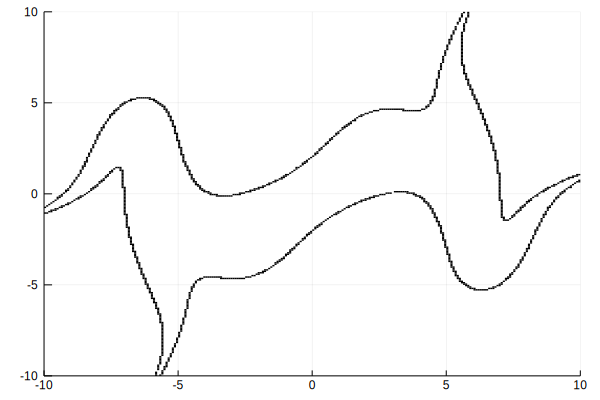

In [11]:
G = plot()
plot!(G, _Punder ⩵ 0., xlims=(-10, 10), ylims=(-10, 10), color="red")
plot!(G, _Pover ⩵ 0., xlims=(-10, 10), ylims=(-10, 10), color="blue")
G

In [12]:
G = plot()
Gu = plot(_Punder ≪ 0., xlims=(-10, 10), ylims=(-10, 10))
Go = plot(_Pover ≪ 0., xlims=(-10, 10), ylims=(-10, 10))
plot(Gu, Go)

### Plots using IntervalConstraintProgramming

In [13]:
using IntervalConstraintProgramming, ValidatedNumerics

┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.0/ValidatedNumerics/EHj5c.ji for ValidatedNumerics [d621b6e3-7715-5857-9c6f-c67000ef6083]
└ @ Base loading.jl:1190


In [14]:
@function Funder(x₁, x₂) = _Punder(x₁, x₂)

LoadError: ArgumentError: Function _Punder not available. Use @function to define it.

In [15]:
Bx₁x₂ = IntervalBox(-10..10, -10..10)

[-10, 10] × [-10, 10]

In [16]:
Cunder = IntervalConstraintProgramming.@constraint Funder(x₁, x₂) <= 0.0 # no

LoadError: ArgumentError: Function Funder not available. Use @function to define it.

In [17]:
paving = pave(Cunder, Bx₁x₂)

UndefVarError: UndefVarError: Cunder not defined